In [13]:
# Library
import random
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
import pandas as pd 
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import tensorflow


In [14]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(2, activation = "relu"),
        tf.keras.layers.Dense(2, activation = "relu"),
        tf.keras.layers.Dense(2),
    ]
)

x = tf.ones((3, 2))
y = model(x)

In [15]:
y

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

# Idee

- tf.math.softmax() erzwingt bereits die Gewichtseigenschaften.
- Eine Lossfunktion schreiben welche diese Eigenschaft einfach ausnutzt

$$
     || \vec{y} - \vec{\hat{y}}(w) ||^2 + 2  \sigma^2 \vec{w}^T \vec{\rho}
$$

Hierbei sein $y(w)$ wie folgt definiert (angeommen wir haben nur zwei Modelle)
\begin{align*}
     & \hat{y}(w) = \sum \hat{y}_k w_k  = \vec{y} \vec{w} \\
     & \vec{w} = softmax(w_1, w_2)
\end{align*}

# Einfaches Beispiel:

 Erst einmal ohne Noise anschauen. Wenn es klappt dann mit Noise.

Wahres Gewicht: $\vec{w} = (0.2, 0.8)$ <br>
Freiheitsgrade: $\vec{\rho} = (2,3)$ <br>
Varianz: $\sigma^2 = 1.0$ <br>

In [16]:
np.random.seed(seed=42)

In [34]:
# Anzahl Beobachtungen:
n = 200
# Gewichte (w):
w = np.array((0.2, 0.8))
# Noise (noise):
noise = np.random.normal(loc=0.0, scale=1.0, size=n)
noise = noise.reshape(n, 1)
# Inputs berechnen:
X1 = np.random.uniform(low=0.0, high=1.0, size=n)
X1 = X1.reshape(n)
X2 = np.random.uniform(low=0.0, high=1.0, size=(n * 2))
X2 = X2.reshape(n, 2)
# beta1 (b):
beta = np.array((3))
# eta1 und eta2 (e1, e2):
eta = np.array((2, 4))
eta = eta.reshape(2, 1)
# y1 berechnen (y1):
y_1 = 1 + X1 * beta
y1 = w[0]*y_1
y1 = y1.reshape(n , 1)
# y2 berechnen (y2):
y_2 = 1 + np.matmul(X2, eta)
y2 = w[1]*y_2
# Zusammengesetzte Beobachtungen (Y):
Yn = y1 + y2 + noise
Y = y1 + y2
yhat_temp = np.column_stack((y_1, y_2))
trainings_data = np.column_stack((yhat_temp, Yn))

# Lossfunktion aufstellen


$$
     || \vec{y} - \vec{\hat{y}}(w) ||^2 + 2  \sigma^2 \vec{w}^T \vec{\rho}
$$

In [4]:
def my_loss(y, yhat1, yhat2, gewichte):
    # yhat vector erstellen:
    yhat_temp = np.column_stack((yhat1, yhat2))
    # gewichteter yhat
    yw_temp = (LA.norm(y - (np.matmul(yhat_temp, tf.math.softmax(gewichte).numpy()))))**2
    return yw_temp

loss = lambda: (LA.norm(Y - (np.matmul(yhat_temp, tf.math.softmax(var1)))))**2 



In [5]:
test = np.array((1.0, 2.0, 0.3))
temp = tf.math.softmax(test)
temp.numpy()

2022-03-15 14:29:04.793195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-15 14:29:04.793308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


array([0.2372554 , 0.64492705, 0.11781755])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
# Weight Constraint class
class softmax_const(tf.keras.constraints.Constraint):
  """Constrains weight tensors to be centered around `ref_value`."""

  def __call__(self, w):
    # temp = tf.exp(w) / tf.reduce_sum(tf.exp(w))
    ratio = tf.exp(w[0]) / tf.reduce_sum(tf.exp(w))
    temp
    return temp

tf.math.less_equal/greater_equal : boolean <br>
tf.cast : trägt Boolean auf float um <br>


# Lossfunction

In [7]:
opt = tf.keras.optimizers.SGD(
            learning_rate=0.001, momentum=0.0, nesterov=False, name='SGD'
            )

In [44]:
tf.random.set_seed(42)
model0 = tf.keras.Sequential()
# model0.add(tf.keras.layers.Dense(1, use_bias = False, kernel_constraint=softmax_const(), activation='linear', batch_input_shape=(None, 2)))
model0.add(tf.keras.layers.Dense(1, use_bias = False, activation='linear', batch_input_shape=(None, 2)))
model0.compile(loss='MeanSquaredError', optimizer=opt)
hist0 = model0.fit(yhat_temp, Yn, epochs = 10000, batch_size=n, use_multiprocessing=True, verbose=0)

2022-03-15 14:47:03.220373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


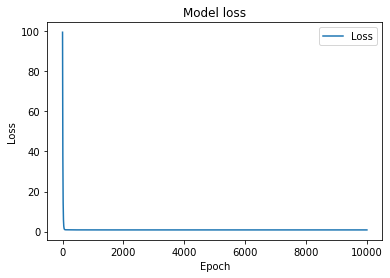

In [45]:
plt.plot(hist0.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.show()

In [47]:
np.mean(Yn - tf.linalg.matmul(yhat_temp, model0.get_weights()[0]))

0.0025143828005792022

In [48]:
temp_w = w.reshape(2, 1)
np.mean(Yn - tf.linalg.matmul(yhat_temp, temp_w))

-0.04077096517208499

In [49]:
model0.get_weights()

[array([[0.17173892],
        [0.80662304]], dtype=float32)]

In [16]:
 tf.exp(model0.get_weights()[0][0]) / tf.reduce_sum(tf.exp(model0.get_weights()[0]))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.35434663], dtype=float32)>

In [35]:
 tf.reduce_sum(tf.exp(yhat_temp[:, 1])) / tf.reduce_sum(tf.exp(yhat_temp))

<tf.Tensor: shape=(), dtype=float64, numpy=0.8788818343840307>

In [33]:
tf.reduce_sum(tf.exp(yhat_temp))

<tf.Tensor: shape=(), dtype=float64, numpy=28377.16011558871>

In [36]:
tf.nn.softmax(yhat_temp)

<tf.Tensor: shape=(200, 2), dtype=float64, numpy=
array([[0.311802  , 0.688198  ],
       [0.13901266, 0.86098734],
       [0.09894211, 0.90105789],
       [0.14229327, 0.85770673],
       [0.07093473, 0.92906527],
       [0.01557354, 0.98442646],
       [0.51626256, 0.48373744],
       [0.16788991, 0.83211009],
       [0.19145631, 0.80854369],
       [0.33635219, 0.66364781],
       [0.0377157 , 0.9622843 ],
       [0.57194799, 0.42805201],
       [0.0444895 , 0.9555105 ],
       [0.19124324, 0.80875676],
       [0.68968641, 0.31031359],
       [0.51164097, 0.48835903],
       [0.76705663, 0.23294337],
       [0.00754238, 0.99245762],
       [0.08211435, 0.91788565],
       [0.02679735, 0.97320265],
       [0.42920642, 0.57079358],
       [0.00666514, 0.99333486],
       [0.0321183 , 0.9678817 ],
       [0.21893754, 0.78106246],
       [0.01131676, 0.98868324],
       [0.82872168, 0.17127832],
       [0.01976966, 0.98023034],
       [0.0784081 , 0.9215919 ],
       [0.43929514, 0.5607

# Per hand alles selber schreiben


In [56]:
# Custom loss
loss_obj = tf.keras.losses.MeanSquaredError()
def my_loss(model, x, y):
    y_ = model(x)
    return loss_obj(y_true = y, y_pred = y_)

In [57]:
# Gradient 
def grad(model, inputs, outputs):
    with tf.GradientTape() as tape:
        loss_value = my_loss(model, inputs, outputs)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

optim = tf.keras.optimizers.Adam(learning_rate=0.01)

In [58]:
# Model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, use_bias=False, activation="linear", input_shape=(None, 2)),  # input shape required
])

In [59]:
# training setup    
train_loss_results = [ ]
train_acc_results = [ ]
num_epochs = 200

In [60]:
# training loop

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()

  for x1, x2, y in trainings_data:
    loss_value, grads = grad(model, inputs = np.column_stack((x1, x2)), outputs = y)
    optim.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())

  if epoch % 5 == 0:
    print("Epoch {:03d}: Loss: {:.7f}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                ))

Epoch 000: Loss: 1.0355825
Epoch 005: Loss: 0.9362320
Epoch 010: Loss: 0.9364091
Epoch 015: Loss: 0.9364586
Epoch 020: Loss: 0.9364738
Epoch 025: Loss: 0.9364791
Epoch 030: Loss: 0.9364806
Epoch 035: Loss: 0.9364815
Epoch 040: Loss: 0.9364819
Epoch 045: Loss: 0.9364821
Epoch 050: Loss: 0.9364819
Epoch 055: Loss: 0.9364820
Epoch 060: Loss: 0.9364820
Epoch 065: Loss: 0.9364819
Epoch 070: Loss: 0.9364819
Epoch 075: Loss: 0.9364819
Epoch 080: Loss: 0.9364819
Epoch 085: Loss: 0.9364820
Epoch 090: Loss: 0.9364819
Epoch 095: Loss: 0.9364819
Epoch 100: Loss: 0.9364819
Epoch 105: Loss: 0.9364819
Epoch 110: Loss: 0.9364819
Epoch 115: Loss: 0.9364819
Epoch 120: Loss: 0.9364819
Epoch 125: Loss: 0.9364819
Epoch 130: Loss: 0.9364819
Epoch 135: Loss: 0.9364819
Epoch 140: Loss: 0.9364819
Epoch 145: Loss: 0.9364819
Epoch 150: Loss: 0.9364819
Epoch 155: Loss: 0.9364819
Epoch 160: Loss: 0.9364819
Epoch 165: Loss: 0.9364819
Epoch 170: Loss: 0.9364819
Epoch 175: Loss: 0.9364819
Epoch 180: Loss: 0.9364819
E

In [61]:
model.get_weights()

[array([[0.28553817],
        [0.7516919 ]], dtype=float32)]

In [47]:
for x1, x2, y in trainings_data:
    print( [x1, x2], y)

[1.2609602797342303, 4.523029859947315] 5.116701136402328
[2.2253596392120962, 4.310198416814308] 1.8198404288857164
[2.118065551036942, 4.987534214964318] 4.0709528880984935
[1.7792613512809785, 5.442245146889565] 4.338207521772056
[3.170260341065755, 5.550889069681314] 3.667251629240381
[2.487627205236312, 4.119997871583456] 3.015707050723152
[1.2431386477229438, 1.267006826781576] 0.15165734550402066
[1.660549605849434, 3.3658576039796926] 4.777066447777264
[3.0497762909787878, 5.645221289881993] 6.0618106832488134
[1.2283925784709004, 4.1873863801922635] 4.86714271484215
[3.553620742146306, 3.1760250370323364] 3.9732162420983657
[2.485439581041923, 3.1357358931220456] 1.8766248594887922
[2.441759731979944, 5.048764626534471] 4.0028433813437925
[2.777223353978553, 4.778261480039727] 4.86742841605541
[3.4740428977754476, 5.467030835176048] 3.846305438803982
[2.043427623706579, 4.488287435516339] 4.712313903326775
[3.0340484576771907, 3.9230569088435523] 3.504929820452145
[2.697195891

# Zusammenführung händisch machen

https://stackoverflow.com/questions/62081237/is-there-a-way-to-train-a-tensorflow-keras-model-manually-without-using-the-fit

In [88]:
# Custom loss
loss_obj = tf.keras.losses.MeanSquaredError()
def my_loss(model, x, y):
    y_ = model(x)
    return loss_obj(y_true = y, y_pred = y_)

In [63]:
# Gradient
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(outputs, model(inputs))
  dW = t.gradient(current_loss, [model.W])
  model.W.assign_sub(learning_rate * dW)

In [66]:
# custom class model
class MyModel(tf.keras.Model):
    def __init__(self):
        self.W = tf.Variable([])

    def call(self, inputs, weights):
        temp = tf.linalg.matmul(inputs, weights)
        return temp

class Model(object):
  def __init__(self):
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

In [67]:
model = MyModel()

In [85]:
outputs = tf.constant([Yn])
inputs = tf.constant([yhat_temp])

In [89]:
Ws = [ ]
epochs = range(10)
for epoch in epochs:
  # Ws.append(model.W.numpy())
  current_loss = my_loss(outputs, model(inputs))

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

TypeError: call() missing 1 required positional argument: 'weights'

# todos

Ich muss eine trainierbare Variable einbauen. Im Stackoverflow Beispiel steht es als ws. bs sei hierbei der intercept und der kann weg.

____

# Spline 1: c_age
plt.plot(m1_plot["c_age"], m1_plot["m1_pred"])
plt.ylim(-1.5, 1.5)
plt.show()
____

# Spline 2: c_breastf
plt.plot(m2_plot["c_breastf"], m2_plot["m2_pred"])
plt.ylim(-1.5, 1.5)
plt.show()

# Neuronales Netz 1: c_breastf
plt.plot(m1_plot)
plt.show